# 0. Online Retail

* 데이터셋 : https://archive.ics.uci.edu/ml/datasets/Online+Retail#

<br>

## Attribute Information:

- InvoiceNo: 송장번호. 해당 거래에 할당된 6자리 정수
  * 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
  * 실제 비즈니스에서는 취소건에 업데이트를 하기보다는 새로운 레코드를 하나 더 생성합니다.
      * 주문-취소가 짝이 되도록 만듭니다. 
      * 언제 주문이 일어났고 언제 취소가 되었는지 알기 위해 로그를 남기는 방식으로 구현해요.
      * 카드 결제 데이터는 취소가 마이너스 승인입니다.
- StockCode: 제품 코드. 각 고유 제품에 고유하게 할당된 5자리 정수
- Description: 제품 이름
- Quantity: 거래당 각 제품의 수량 
  * 이 코드가 ‘-’(마이너스)로 시작하면 취소를 나타냅니다.
- InvoiceDate:  송장 날짜 및 시간. 숫자, 각 거래가 생성된 날짜 및 시간
- UnitPrice: 단가. 숫자, 스털링(영국 화폐) 단위의 제품 가격
- CustomerID: 고객 번호. 해당 고객에게 고유하게 할당된 5자리 정수
- Country: 국가 이름. 해당 고객이 거주하는 국가의 이름

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

## 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
df = pd.read_csv("/gdrive/My Drive/Colab Notebooks/data/online_retail.csv")

In [4]:
df.shape

(541909, 8)

## 유효 데이터만 추출

* 취소와 취소에 대한 본 주문건 제거
* 고객ID가 없는 건도 제거

In [5]:
# "CustomerID" 가 있고 "Quantity" , "UnitPrice"가 0보다 큰 데이터를 가져옵니다.
# 구매하고 취소한 건 중 취소한 건만 제외하고 구매 건은 남깁니다.
df = df[df["CustomerID"].notnull() & (df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()
df.shape

(397884, 8)

In [6]:
# 중복 데이터 제거
df = df.drop_duplicates()
df.shape

(392692, 8)

# 1. EDA

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [8]:
df.describe(include="object")

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,392692,392692,392692,392692,392692
unique,18532,3665,3877,17282,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-11-14 15:27:00,United Kingdom
freq,542,2023,2016,542,349203


In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
# 비회원
df.loc[df["CustomerID"].isnull(), "Country"].value_counts()

Series([], Name: Country, dtype: int64)

In [11]:
# 회원
df.loc[df["CustomerID"].notnull(), "Country"].value_counts()

United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

## 판매액

In [12]:
df["TotalPrice"] = df["UnitPrice"] * df["Quantity"]

In [13]:
# 나라별
df.groupby("Country")["TotalPrice"].agg(["mean", "sum"]).nlargest(10, "sum").style.format("{:,.0f}")

,mean,sum
Country,,
United Kingdom,21,"7,285,025"
Netherlands,121,"285,446"
EIRE,37,"265,262"
Germany,25,"228,678"
France,25,"208,934"
Australia,117,"138,454"
Spain,25,"61,559"
Switzerland,31,"56,444"
Belgium,20,"41,196"


In [14]:
# 판매 빈도가 높은 상품 상위 10개
stock_sale = df.groupby(["StockCode"]).agg({"InvoiceNo": "count", 
                               "Quantity": "sum",
                               "TotalPrice": "sum"
                              }).nlargest(10, "InvoiceNo")
stock_sale

,InvoiceNo,Quantity,TotalPrice
StockCode,,,
85123A,2023,36763,100547.45
22423,1713,12374,142264.75
85099B,1615,46078,85040.54
84879,1395,35263,56413.03
47566,1389,15279,68785.23
20725,1304,17776,28158.80
22720,1152,7010,33298.30
POST,1099,3120,77803.96
23203,1091,19498,37646.94


## 구매 취소 비율

In [90]:
# 고객별 구매취소 비율 상위 CustomerID 10개
df.groupby("CustomerID")["Cancel"].value_counts().unstack().nlargest(10, False)

Cancel,False
CustomerID,
17841.0,7676
14911.0,5670
14096.0,5111
12748.0,4412
14606.0,2677
15311.0,2366
14646.0,2076
13089.0,1814
13263.0,1667


### 제품별 구매 취소 비율

In [18]:
cancel_stock = df.groupby(["StockCode"]).agg({"InvoiceNo":"count", "Cancel": "mean"})
cancel_stock.columns = ["count", "mean"]
cancel_stock.nlargest(10, "count")

,count,mean
StockCode,,
85123A,2023,0.0
22423,1713,0.0
85099B,1615,0.0
84879,1395,0.0
47566,1389,0.0
20725,1304,0.0
22720,1152,0.0
POST,1099,0.0
23203,1091,0.0


### 국가별 구매 취소 비율

In [19]:
cancel_country = df.groupby("Country").agg({"InvoiceNo": "count", "Cancel": "mean"})
cancel_country.nlargest(20, "Cancel")

,InvoiceNo,Cancel
Country,,
Australia,1181,0.0
Austria,398,0.0
Bahrain,17,0.0
Belgium,2031,0.0
Brazil,32,0.0
Canada,151,0.0
Channel Islands,747,0.0
Cyprus,603,0.0
Czech Republic,25,0.0


## 날짜와 시간

- 파생변수 만들기

In [20]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [21]:
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceMonth"] = df["InvoiceDate"].dt.month
df["InvoiceDay"] = df["InvoiceDate"].dt.day
df["InvoiceDow"] = df["InvoiceDate"].dt.dayofweek
df["InvoiceTime"] = df["InvoiceDate"].dt.time
df["InvoiceHour"] = df["InvoiceDate"].dt.hour
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Cancel,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,InvoiceTime,InvoiceHour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,False,2010,12,1,2,08:26:00,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,2010,12,1,2,08:26:00,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,False,2010,12,1,2,08:26:00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,2010,12,1,2,08:26:00,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,False,2010,12,1,2,08:26:00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,False,2011,12,9,4,12:50:00,12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,False,2011,12,9,4,12:50:00,12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,False,2011,12,9,4,12:50:00,12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,False,2011,12,9,4,12:50:00,12


<AxesSubplot:xlabel='InvoiceYear', ylabel='count'>

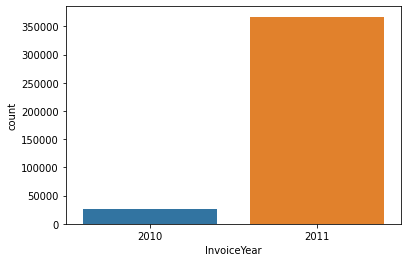

In [22]:
sns.countplot(data=df, x="InvoiceYear")

In [24]:
# 데이터들이 2020.12.01 부터 2021.12.01까지라 애매해서 그냥 다 2021로 만들어버림
df["InvoiceYear"] = 2011

<AxesSubplot:xlabel='InvoiceYear', ylabel='count'>

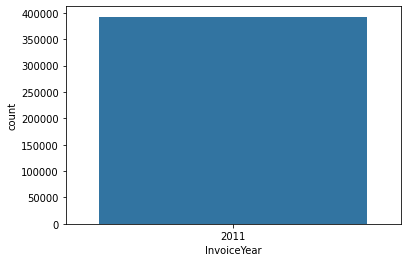

In [25]:
sns.countplot(data=df, x="InvoiceYear")

<AxesSubplot:xlabel='InvoiceMonth', ylabel='count'>

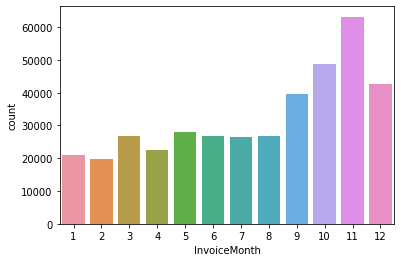

In [26]:
sns.countplot(data=df, x="InvoiceMonth")

<AxesSubplot:xlabel='InvoiceDow', ylabel='count'>

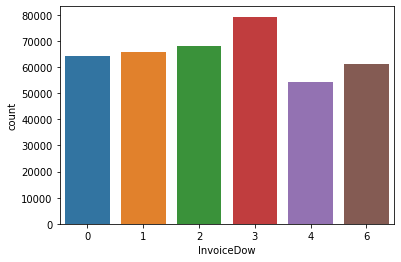

In [27]:
sns.countplot(data=df, x="InvoiceDow")

<AxesSubplot:xlabel='InvoiceHour', ylabel='count'>

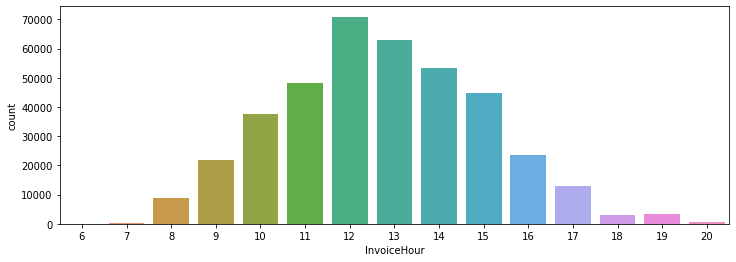

In [29]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x="InvoiceHour")

In [30]:
hour_dow = pd.crosstab(index=df["InvoiceHour"], columns=df["InvoiceDow"])
hour_dow

InvoiceDow,0,1,2,3,4,6
InvoiceHour,,,,,,
6,0,0,0,1,0,0
7,61,65,59,64,130,0
8,1563,1710,1818,1763,1833,0
9,4345,4542,4078,4569,4368,25
10,6106,6575,6927,7528,7161,3476
11,7401,8418,8292,7134,7189,9931
12,10585,11903,12684,12908,9765,13093
13,10459,10274,11137,11446,8300,11403
14,9119,9428,8716,9173,7227,9588


In [31]:
hour_dow.style.background_gradient().format("{:,}")

InvoiceDow,0,1,2,3,4,6
InvoiceHour,,,,,,
6,0,0,0,1,0,0
7,61,65,59,64,130,0
8,"1,563","1,710","1,818","1,763","1,833",0
9,"4,345","4,542","4,078","4,569","4,368",25
10,"6,106","6,575","6,927","7,528","7,161","3,476"
11,"7,401","8,418","8,292","7,134","7,189","9,931"
12,"10,585","11,903","12,684","12,908","9,765","13,093"
13,"10,459","10,274","11,137","11,446","8,300","11,403"
14,"9,119","9,428","8,716","9,173","7,227","9,588"


<AxesSubplot:xlabel='InvoiceHour'>

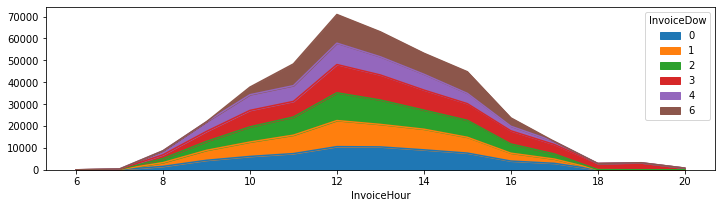

In [33]:
hour_dow.plot.area(figsize=(12, 3))

# 2. ARPU / ARPPU
* ARPU(Average Revenue Per User) : 
    * 가입한 서비스에 대해 가입자 1명이 특정 기간 동안 지출한 평균 금액
    * ARPU = 매출 / 중복을 제외한 순수 활동 사용자 수
* ARPPU(Average Revenue Per Paying User):
    * 지불 유저 1명 당 한 달에 결제하는 평균 금액을 산정한 수치

In [34]:
arppu = df.groupby("InvoiceMonth").agg({
    "TotalPrice":"sum", "CustomerID": "nunique"})
arppu.columns = ["sale_sum", "customer_count"]
arppu["ARPPU"] = arppu["sale_sum"] / arppu["customer_count"]
arppu.style.format("{:,.0f}")

,sale_sum,customer_count,ARPPU
InvoiceMonth,,,
1,"568,101",741,767
2,"446,085",758,589
3,"594,082",974,610
4,"468,374",856,547
5,"677,355","1,056",641
6,"660,046",991,666
7,"598,963",949,631
8,"644,051",935,689
9,"950,690","1,266",751


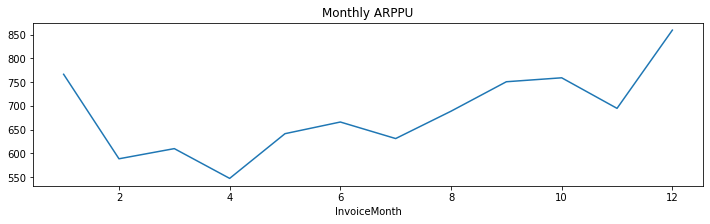

In [35]:
arppu["ARPPU"].plot(figsize=(12, 3), title="Monthly ARPPU");

In [36]:
cust_agg = df.groupby(["CustomerID"]).agg({
    "InvoiceNo":["nunique", "count"], 
    "TotalPrice":["mean", "sum"]})
cust_agg.columns = ["nunique", "count", "mean", "sum"]
cust_agg

,nunique,count,mean,sum
CustomerID,,,,
12346.0,1,1,77183.600000,77183.60
12347.0,7,182,23.681319,4310.00
12348.0,4,31,57.975484,1797.24
12349.0,1,73,24.076027,1757.55
12350.0,1,17,19.670588,334.40
...,...,...,...,...
18280.0,1,10,18.060000,180.60
18281.0,1,7,11.545714,80.82
18282.0,2,12,14.837500,178.05


In [37]:
cust_agg.describe()

,nunique,count,mean,sum
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,4.272015,90.523744,68.381590,2048.688081
std,7.697998,225.506968,1467.918294,8985.230220
min,1.000000,1.000000,2.136970,3.750000
25%,1.000000,17.000000,12.393196,306.482500
50%,2.000000,41.000000,17.755000,668.570000
75%,5.000000,98.000000,24.878950,1660.597500
max,209.000000,7676.000000,77183.600000,280206.020000


#3. MAU(Monthly Active User)

<AxesSubplot:title={'center':'MAU(Monthly Active User)'}, xlabel='InvoiceMonth'>

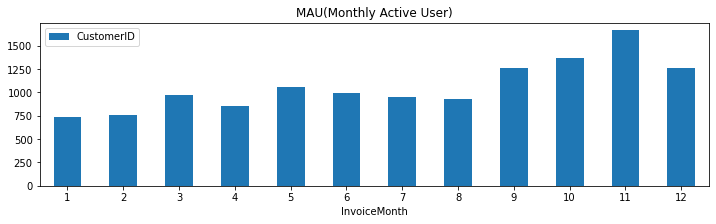

In [38]:
# InvoiceYM 으로 그룹화 하여 CustomerID 의 유일값의 개수를 구합니다.
# MAU 는 기준을 다르게 정하기도 하는데 로그인 수로 세기도 하고 여기에서는 구매 데이터만 있기 때문에 구매수로 구했습니다. 
mau = df.groupby(["InvoiceMonth"]).agg({"CustomerID": "nunique"})
mau.plot.bar(figsize=(12, 3), rot=0, title="MAU(Monthly Active User)")

## 월별, 주문건, 중복을 제외한 주문제품 종류 수, 고객 수, 총 주문금액

In [39]:
df.groupby("InvoiceMonth").agg({"InvoiceNo" : "count", 
                             "StockCode": "nunique",
                             "CustomerID": "nunique",
                             "UnitPrice" : "sum",
                             "Quantity" : "sum",
                             "TotalPrice" : "sum"
                            })

,InvoiceNo,StockCode,CustomerID,UnitPrice,Quantity,TotalPrice
InvoiceMonth,,,,,,
1,20988,2121,741,66234.650,348473,568101.310
2,19706,2124,758,62619.480,265027,446084.920
3,26870,2234,974,87864.790,347582,594081.760
4,22433,2217,856,78543.481,291366,468374.331
5,28073,2219,1056,101500.910,372864,677355.150
6,26926,2339,991,84602.660,363014,660046.050
7,26580,2351,949,75454.521,367360,598962.901
8,26790,2356,935,78877.090,397373,644051.040
9,39669,2545,1266,118160.322,543652,950690.202


## 월단위 데이터 전처리

In [40]:
# 확인 용도로 CustomerID 별 해당구매월 의 최솟값을 봅니다.
df.groupby("CustomerID")["InvoiceMonth"].min()

CustomerID
12346.0     1
12347.0     1
12348.0     1
12349.0    11
12350.0     2
           ..
18280.0     3
18281.0     6
18282.0     8
18283.0     1
18287.0     5
Name: InvoiceMonth, Length: 4338, dtype: int64

In [41]:
df["InvoiceDateMin"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min")

In [42]:
df[["CustomerID", "InvoiceDate", "InvoiceDateMin", "InvoiceMonth"]]

,CustomerID,InvoiceDate,InvoiceDateMin,InvoiceMonth
0,17850.0,2010-12-01 08:26:00,12,12
1,17850.0,2010-12-01 08:26:00,12,12
2,17850.0,2010-12-01 08:26:00,12,12
3,17850.0,2010-12-01 08:26:00,12,12
4,17850.0,2010-12-01 08:26:00,12,12
...,...,...,...,...
541904,12680.0,2011-12-09 12:50:00,8,12
541905,12680.0,2011-12-09 12:50:00,8,12
541906,12680.0,2011-12-09 12:50:00,8,12
541907,12680.0,2011-12-09 12:50:00,8,12


### 첫 구매일로 부터 몇 달째 구매인가?

In [44]:
month_diff = df["InvoiceMonth"] - df["InvoiceDateMin"]

In [46]:
# "월차이 + 1"로 첫 구매 후 몇달 후 구매인지 알 수 있도록 CohortIndex 변수를 생성합니다.
# 2011-01-01부터 2011-12-31의 데이터를 기반으로 진행되어 CohortIndex 변수의 최소값은 1이며, 최대값 12입니다.
df["CohortIndex"] = month_diff + 1
df[["CustomerID", "InvoiceMonth", "InvoiceDateMin", "CohortIndex"]]

,CustomerID,InvoiceMonth,InvoiceDateMin,CohortIndex
0,17850.0,12,12,1
1,17850.0,12,12,1
2,17850.0,12,12,1
3,17850.0,12,12,1
4,17850.0,12,12,1
...,...,...,...,...
541904,12680.0,12,8,5
541905,12680.0,12,8,5
541906,12680.0,12,8,5
541907,12680.0,12,8,5


### 코호트 월별 빈도수

In [47]:
df["CohortIndex"].value_counts().sort_index()

1     115677
2      26729
3      29790
4      26028
5      27236
6      26337
7      25090
8      24809
9      26474
10     22366
11     24499
12     17657
Name: CohortIndex, dtype: int64

<AxesSubplot:xlabel='CohortIndex', ylabel='count'>

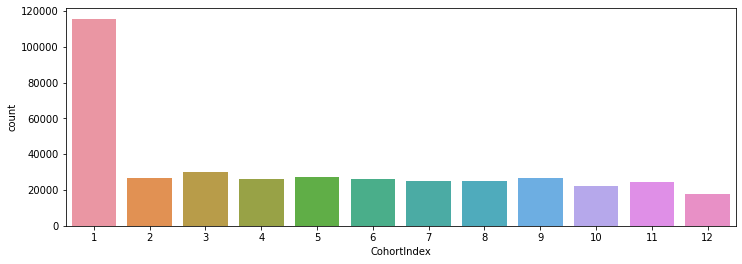

In [48]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x="CohortIndex")

## 잔존 빈도 구하기

In [49]:
cohort_count = df.groupby(["InvoiceDateMin", "CohortIndex"])["CustomerID"].nunique().unstack()
cohort_count.index = cohort_count.index.astype(str).str[:7]

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
InvoiceDateMin,,,,,,,,,,,,
1,741.0,262.0,319.0,284.0,339.0,311.0,290.0,285.0,325.0,309.0,381.0,373.0
2,496.0,116.0,123.0,169.0,155.0,135.0,151.0,163.0,153.0,181.0,142.0,NaN
3,539.0,88.0,144.0,120.0,123.0,101.0,153.0,130.0,162.0,126.0,NaN,NaN
4,361.0,85.0,79.0,85.0,76.0,85.0,88.0,107.0,83.0,NaN,NaN,NaN
5,319.0,58.0,56.0,58.0,70.0,77.0,88.0,62.0,NaN,NaN,NaN,NaN
6,268.0,47.0,41.0,68.0,60.0,91.0,49.0,NaN,NaN,NaN,NaN,NaN
7,213.0,38.0,47.0,49.0,57.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN
8,185.0,39.0,47.0,46.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,316.0,76.0,100.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='InvoiceDateMin'>

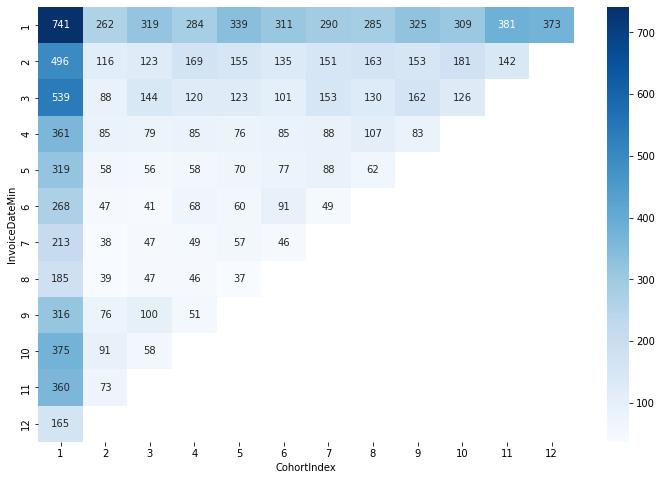

In [50]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_count, annot=True, fmt=".0f", cmap="Blues")

### 월별 신규 유입 고객 수 

<AxesSubplot:xlabel='InvoiceDateMin'>

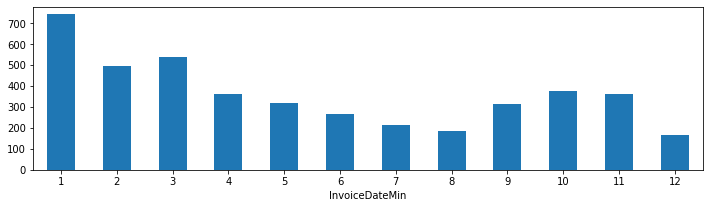

In [52]:
cohort_count[1].plot.bar(figsize=(12, 3), rot=0)

## 잔존율 구하기

In [91]:
# 가입한 달을 1로 나누면 잔존률을 구할 수 있습니다.
# div 를 통해 구하며 axis=0 으로 설정하면 첫 달을 기준으로 나머지 달을 나누게 됩니다.
cohort_norm = cohort_count.div(cohort_count[1], axis=0)

<AxesSubplot:xlabel='CohortIndex', ylabel='InvoiceDateMin'>

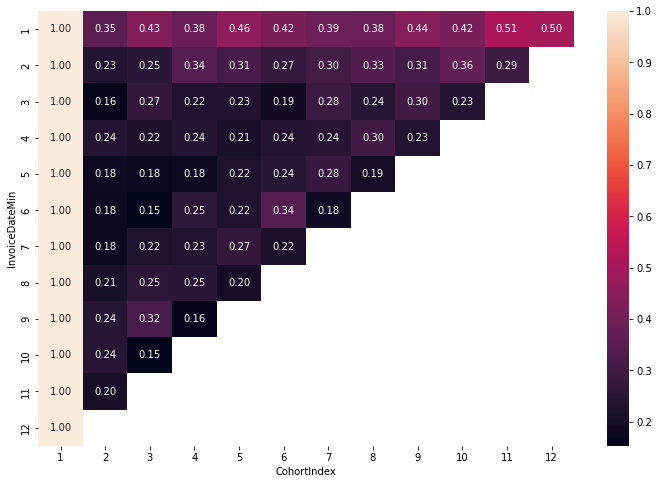

In [92]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_norm, annot=True, fmt=".2f")

# 4. RFM

In [56]:
# Recency 계산을 위해 해당 주문에서 가장 최근 구매가 일어난 시간을 가져옵니다.
# 최근 거래 기준일(last_timestamp)을 만들기 위해 timedelta로 날짜를 더해줍니다.(최소값:1 설정)
# 최근 영업일과 같은 날에 마지막으로 거래를 했다면 0 으로 될텐데 마지막 거래일자에 거래한 값이 1이 되게 하기 위해서 입니다.
# 리텐션을 구할 때도 코호트 인덱스 값을 1로 설정한 것 처럼 0부터 시작하지 않고 1부터 시작하도록 1을 더해주었습니다.
last_timestamp = df["InvoiceDate"].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2011-12-10 12:50:00')

### 고객별 Recency, Frequency, Monetary 값 구하기

In [57]:
# 가장 앞에 있는 데이터의 최근 구매 일자로 부터의 날짜 차이
(last_timestamp - df["InvoiceDate"]).iloc[0].days

374

In [58]:
# 가장 뒤(최근)에 있는 데이터의 최근 구매 일자로 부터의 날짜 차이
(last_timestamp - df["InvoiceDate"]).iloc[-1].days

1

In [59]:
# RFM 값을 정의합니다.
# Recency : 최근 거래 기준일(last_timestamp)과 고객별 최근 구매한 날짜(x.max())와 차이값
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
rfm = df.groupby("CustomerID").agg({"InvoiceDate" : lambda x : (last_timestamp - x.max()).days, 
                              "InvoiceNo" : "count",
                              "TotalPrice" : "sum"
                             })
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [61]:
# RFM 으로 변수의 이름을 변경합니다.
# InvoiceDate 는 Recency
# InvoiceNo 는 Frequency
# TotalPrice 는 MonetaryValue
rfm = rfm.rename(columns={"InvoiceDate": "Recency", 
                          "InvoiceNo": "Frequency", 
                          "TotalPrice": "MonetaryValue"})
rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


## RFM 모형

In [63]:
# Recency 는 최근일수록 높은 스코어를 갖도록 합니다.
# Frequency, MonetaryValue 는 값이 클 수록 높은 스코어를 갖도록 합니다.
# pd.qcut(range(5), 3, labels=["good", "medium", "bad"])
r_labels = list(range(5, 0, -1))
f_labels = list(range(1, 6))
m_labels = list(range(1, 6))
cut_size = 5

([5, 4, 3, 2, 1], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], 5)

In [64]:
r_cut = pd.qcut(x=rfm["Recency"], q=cut_size, labels=r_labels)
f_cut = pd.qcut(x=rfm["Frequency"], q=cut_size, labels=f_labels)
m_cut = pd.qcut(x=rfm["MonetaryValue"], q=cut_size, labels=m_labels)

for cut_val in [r_cut, f_cut, m_cut]:
    print(cut_val.value_counts(1))
    print("-"*30)

4    0.208391
5    0.200092
1    0.199401
3    0.197787
2    0.194329
Name: Recency, dtype: float64
------------------------------
1    0.213693
4    0.199401
5    0.198709
3    0.195251
2    0.192946
Name: Frequency, dtype: float64
------------------------------
1    0.200092
3    0.200092
5    0.200092
2    0.199862
4    0.199862
Name: MonetaryValue, dtype: float64
------------------------------


In [65]:
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,2,182,4310.00,5,5,5
12348.0,75,31,1797.24,2,3,4
12349.0,19,73,1757.55,4,4,4
12350.0,310,17,334.40,1,2,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,12,178.05,5,1,1


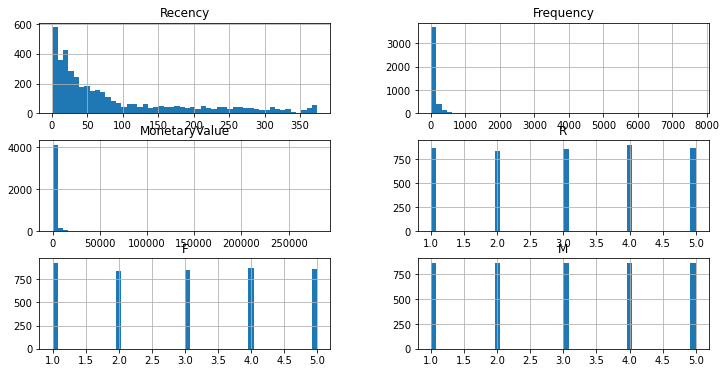

In [66]:
# cut, qcut 으로 나누면 category 형태이기 때문에 시각화를 위해 astype(float)으로 적용 후 시각화 했습니다.
rfm.astype(float).hist(bins=50, figsize=(12, 6));

### RFM Segment

In [67]:
# RFM_segment 값을 구합니다. 
# R, F, M 값을 문자 그대로 붙여서 세그먼트를 구분합니다.
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

### RFM Score

In [68]:
# R, F, M 값의 합계를 구해서 세그먼트 점수를 구합니다.
rfm["RFM_score"] = rfm[["R", "F", "M"]].astype(int).sum(axis=1)
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
CustomerID,,,,,,,,
12346.0,326,1,77183.6,1,1,5,115,7
12347.0,2,182,4310.0,5,5,5,555,15


<AxesSubplot:xlabel='RFM_segment', ylabel='RFM_score'>

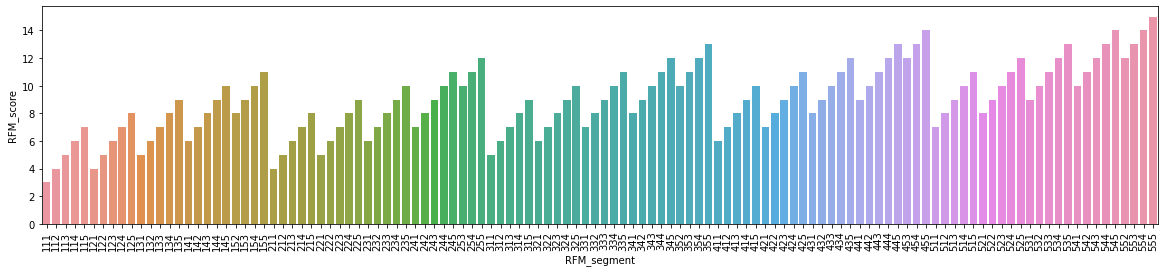

In [69]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values("RFM_segment"), x="RFM_segment", y="RFM_score", ci=None)

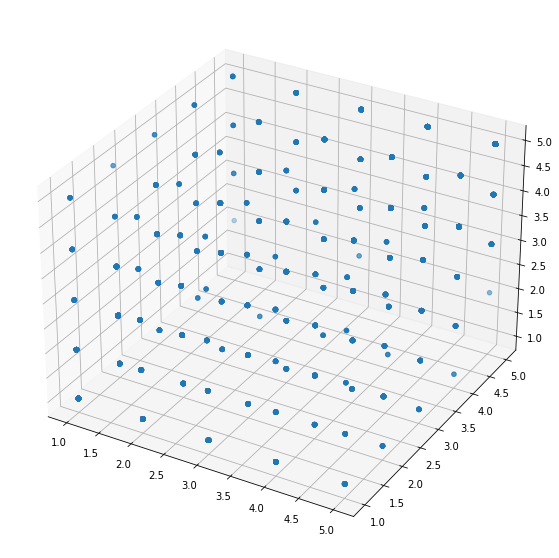

In [70]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["R"], rfm["F"], rfm["M"])

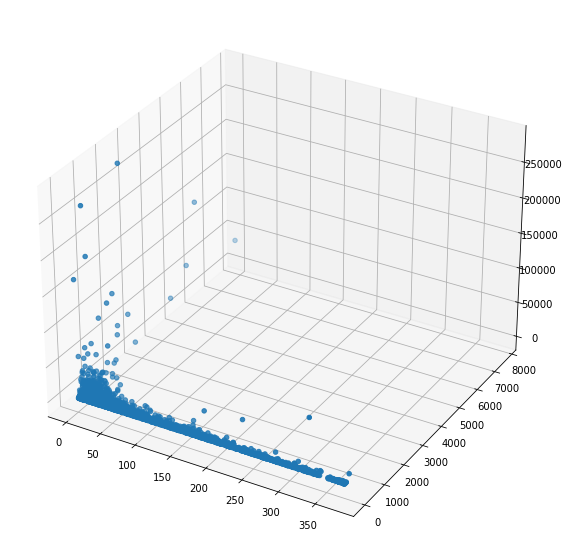

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"])

In [73]:
rfm.groupby("RFM_score").agg({"Recency":"mean", 
                              "Frequency":"mean", 
                              "MonetaryValue":["mean", "sum"]
                             }).style.background_gradient(cmap="coolwarm").format("{:,.0f}")

### qcut을 통한 고객군 나누기

In [77]:
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], q=3, labels=["silver", "gold", "platinum"])
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver
12347.0,2,182,4310.00,5,5,5,555,15,platinum
12348.0,75,31,1797.24,2,3,4,234,9,gold
12349.0,19,73,1757.55,4,4,4,444,12,platinum
12350.0,310,17,334.40,1,2,2,122,5,silver
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,silver
18281.0,181,7,80.82,1,1,1,111,3,silver
18282.0,8,12,178.05,5,1,1,511,7,silver


In [75]:
rfm.groupby("RFM_class")["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,1667.0,5.209358,1.383303,3.0,4.0,5.0,6.0,7.0
gold,1410.0,9.465957,1.115370,8.0,8.0,9.0,10.0,11.0
platinum,1261.0,13.462331,1.125273,12.0,12.0,13.0,14.0,15.0


<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

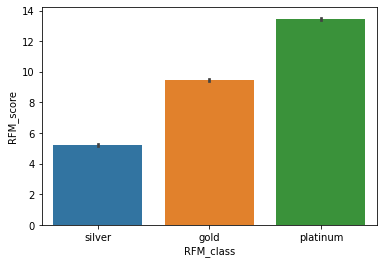

In [78]:
sns.barplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

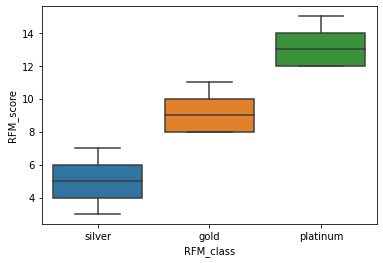

In [79]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot:xlabel='R', ylabel='RFM_score'>

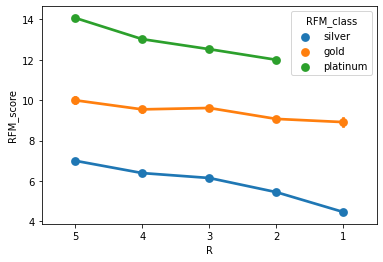

In [80]:
sns.pointplot(data=rfm, x="R", y="RFM_score", hue="RFM_class", errorbar=None)

<AxesSubplot:xlabel='F', ylabel='RFM_score'>

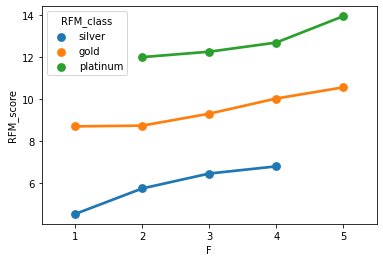

In [82]:
sns.pointplot(data=rfm, x="F", y="RFM_score", hue="RFM_class", ci=None)

<AxesSubplot:xlabel='M', ylabel='RFM_score'>

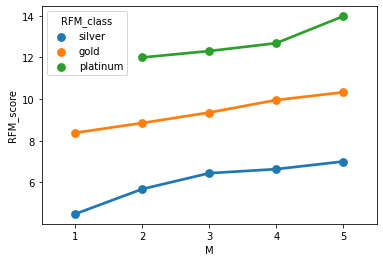

In [83]:
sns.pointplot(data=rfm, x="M", y="RFM_score", hue="RFM_class", ci=None)

In [84]:
rfm.groupby("RFM_class").agg({"Recency":"mean", 
                              "Frequency":"mean",
                              "MonetaryValue": ["mean", "sum", "count"]
                             }).style.background_gradient().format("{:,.0f}")

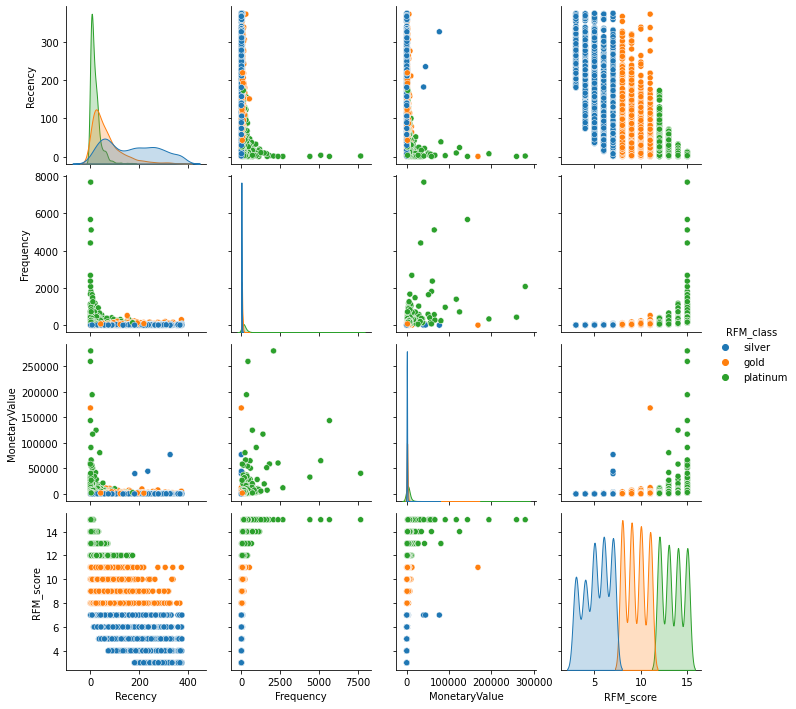

In [85]:
sns.pairplot(rfm, hue="RFM_class")

In [88]:
rfm.to_csv("rfm.csv")

In [89]:
pd.read_csv("rfm.csv")

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
0,12346.0,326,1,77183.60,1,1,5,115,7,silver
1,12347.0,2,182,4310.00,5,5,5,555,15,platinum
2,12348.0,75,31,1797.24,2,3,4,234,9,gold
3,12349.0,19,73,1757.55,4,4,4,444,12,platinum
4,12350.0,310,17,334.40,1,2,2,122,5,silver
...,...,...,...,...,...,...,...,...,...,...
4333,18280.0,278,10,180.60,1,1,1,111,3,silver
4334,18281.0,181,7,80.82,1,1,1,111,3,silver
4335,18282.0,8,12,178.05,5,1,1,511,7,silver
4336,18283.0,4,721,2045.53,5,5,4,554,14,platinum
